In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import json

# Adjustable variables
min_cluster_size = 5  # Default: 5, Recommended range: 1-20
min_samples = 1  # Default: 1, Recommended range: 1-10
cluster_selection_epsilon = 0.0  # Default: 0.0, Recommended range: 0.0-1.0
metric = 'euclidean'  # Default: 'euclidean', Options: 'euclidean', 'cosine', 'manhattan'

with open('tagged_data2.json') as file:
    bookmarks = json.load(file)

# Preprocess the bookmarks data
bookmarks_data = [{"title": bookmark["title"], "url": bookmark["url"], "tags": " ".join(bookmark["tags"])} for bookmark in bookmarks]

# Extract features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform([bookmark["tags"] for bookmark in bookmarks_data])

# PCA dim reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features.toarray())

# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                            cluster_selection_epsilon=cluster_selection_epsilon, metric=metric,
                            gen_min_span_tree=True)
clusterer.fit(reduced_features)

# Build the cluster hierarchy
cluster_hierarchy = {}
for _, row in clusterer.condensed_tree_.to_pandas().iterrows():
    child = row['child']
    parent = row['parent']
    if parent not in cluster_hierarchy:
        cluster_hierarchy[parent] = {'children': []}
    if child not in cluster_hierarchy:
        cluster_hierarchy[child] = {'children': []}
    cluster_hierarchy[parent]['children'].append(child)

# Find the root cluster
root_cluster = None
for cluster_id in cluster_hierarchy:
    if cluster_id not in [child for parent in cluster_hierarchy for child in cluster_hierarchy[parent]['children']]:
        root_cluster = cluster_id
        break

# Map cluster IDs to their corresponding bookmarks
cluster_bookmarks = {}
for i, cluster_id in enumerate(clusterer.labels_):
    if cluster_id not in cluster_bookmarks:
        cluster_bookmarks[cluster_id] = []
    cluster_bookmarks[cluster_id].append(bookmarks_data[i])

# Generate prompts for each cluster considering the hierarchy
def generate_prompts(cluster_id, indent=""):
    prompts = []
    folder_name = f"Folder {cluster_id}"
    if cluster_id in cluster_bookmarks:
        bookmarks = cluster_bookmarks[cluster_id]
        bookmark_titles = [bookmark["title"] for bookmark in bookmarks]
        bookmark_titles_str = "\n".join([f"{indent}  - {title}" for title in bookmark_titles])
        prompt = f"{indent}Folder: {folder_name}\n{bookmark_titles_str}"
        prompts.append(prompt)
   
    if cluster_id in cluster_hierarchy:
        children = cluster_hierarchy[cluster_id]["children"]
        for child_id in children:
            child_prompts = generate_prompts(child_id, indent + "  ")
            prompts.extend(child_prompts)
   
    return prompts

prompts = generate_prompts(root_cluster)

# Print the generated prompts
for prompt in prompts:
    print(prompt)
    print()

            Folder: Folder 1.0
              - http://localhost:5173/
              - Loreteller
              - Life After Epic
              - The Daily Swig | Cybersecurity news and views
              - Half of US population exposed to adverse lead levels in early childhood | PNAS
              - Chat with Open Large Language Models
              - public-apis/public-apis: A collective list of free APIs
              - Translations: | BabyAGI
              - Google Cloud Next
              - TensorFlow Recommenders
              - Find Pre-trained Models | Kaggle
              - Concept2 rowing machine at DuckDuckGo

            Folder: Folder 0.0
              - Agent-OM: Leveraging LLM Agents for Ontology Matching - 2312.00326v2.pdf
              - [2109.02124] The Koha Code: A Biological Theory of Memory
              - Home - RA Benefits
              - 10 Noteworthy AI Research Papers of 2023
              - Log In — WordPress.com
              - macOS support · Issue #22 · uf

TypeError: PCA only support sparse inputs with the "arpack" solver, while "auto" was passed. See TruncatedSVD for a possible alternative.

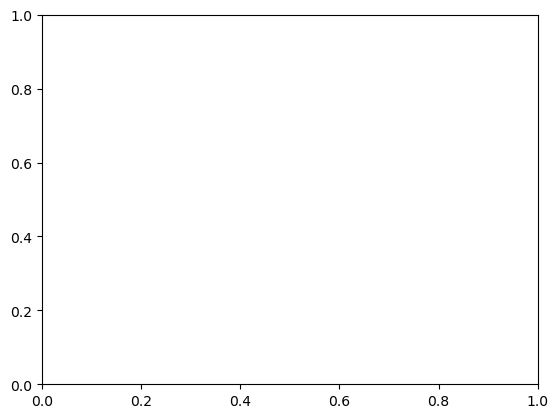

In [39]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=2)

<Axes: ylabel='distance'>

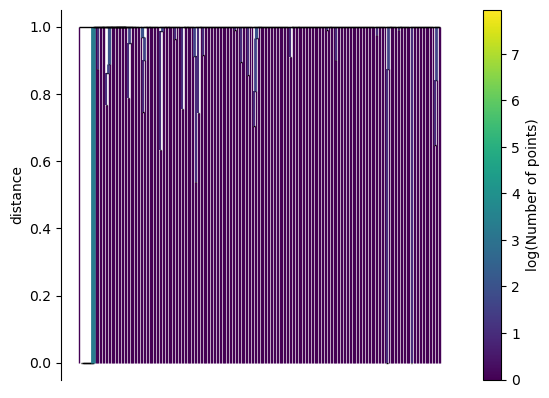

In [ ]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

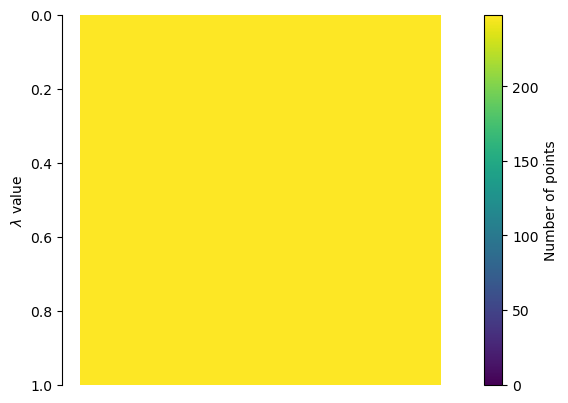

In [ ]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

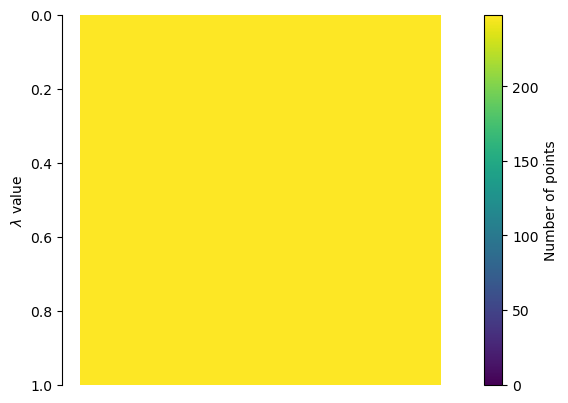

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
# ... (previous code remains the same)

# Generate prompts for each cluster considering the hierarchy
def generate_prompts(cluster_id, indent=""):
    prompts = []
    folder_name = f"Folder {cluster_id}"
    if cluster_id in cluster_bookmarks:
        bookmarks = cluster_bookmarks[cluster_id]
        bookmark_titles = [bookmark["title"] for bookmark in bookmarks]
        bookmark_titles_str = "\n".join(bookmark_titles)
        prompt = f"{indent}Folder: {folder_name}\n{indent}{bookmark_titles_str}\n{indent}Folder Name: "
    else:
        prompt = f"{indent}Folder: {folder_name}\n{indent}Folder Name: "
    
    prompts.append(prompt)

    children = cluster_hierarchy[cluster_id]["children"]
    for child_id in children:
        child_prompts = generate_prompts(child_id, indent + "  ")
        prompts.extend(child_prompts)

    return prompts

prompts = generate_prompts(root_cluster)

# Use an LLM to generate folder names (replace this with your actual LLM code)
folder_names = ["Unnamed Folder" for _ in range(len(prompts))]  # Placeholder for LLM-generated names

# Print the generated prompts and folder names
for prompt, folder_name in zip(prompts, folder_names):
    print(prompt + folder_name)
    print()

# ... (remaining code for visualization remains the same)

Folder: Folder 248.0
Folder Name: Unnamed Folder

  Folder: Folder 247.0
  Folder Name: Unnamed Folder

  Folder: Folder 128.0
  Folder Name: Unnamed Folder

  Folder: Folder 77.0
  Folder Name: Unnamed Folder

  Folder: Folder 55.0
  Folder Name: Unnamed Folder

  Folder: Folder 56.0
  Folder Name: Unnamed Folder

  Folder: Folder 60.0
  Folder Name: Unnamed Folder

  Folder: Folder 61.0
  Folder Name: Unnamed Folder

  Folder: Folder 68.0
  Folder Name: Unnamed Folder

  Folder: Folder 78.0
  Folder Name: Unnamed Folder

  Folder: Folder 81.0
  Folder Name: Unnamed Folder

  Folder: Folder 83.0
  Folder Name: Unnamed Folder

  Folder: Folder 88.0
  Folder Name: Unnamed Folder

  Folder: Folder 89.0
  Folder Name: Unnamed Folder

  Folder: Folder 90.0
  Folder Name: Unnamed Folder

  Folder: Folder 91.0
  Folder Name: Unnamed Folder

  Folder: Folder 92.0
  Folder Name: Unnamed Folder

  Folder: Folder 93.0
  Folder Name: Unnamed Folder

  Folder: Folder 94.0
  Folder Name: Unnamed Fo